In [1]:
import numpy as np
import scipy as sp
import math
from scipy.linalg import expm, sinm, cosm
import scipy.linalg as la
import cvxpy as cp
import matplotlib.pyplot as plt

In [2]:
#A quick way to describe |0>,|1>,|+> and |->
def qubit(a):
    xi=np.zeros(2)
    
    if a=='0':
        xi[0]=1
        return xi
    if a==0:
        xi[0]=1
        return xi
    
    if a=='1':
        xi[1]=1
        return xi
    if a==1:
        xi[1]=1
        return xi
    
    if a=='+':
        xi[0]=1
        xi[1]=1
        xi=xi/la.norm(xi,2)
        return xi
    if a==2:
        xi[0]=1
        xi[1]=1
        xi=xi/la.norm(xi,2)
        return xi
    
    if a=='-':
        xi[0]=1
        xi[1]=-1
        xi=xi/la.norm(xi,2)
        return xi
    if a==3:
        xi[0]=1
        xi[1]=-1
        xi=xi/la.norm(xi,2)
        return xi

In [3]:
#similar to above, a quick way to describe Tensorproducts of |0>,|1>,|+> and |->
def nqubit(a,n):
    if len(a) != n:
        print('unmatching dimensions!')
        return [0]
    else:
        psi=1
        for i in range(n):
            psi=np.kron(psi,qubit(a[i]))
        return psi

In [10]:
def Find_Kappa(mu,m,s,sa,polytope_size=1000):# to solve the dual and find Kappa      (Eq.31)
    A=np.sin(np.outer(mu,np.linspace(0,np.pi,polytope_size)))
    l=cp.Variable(mu.shape[0])
    a=cp.Variable()
    objective = cp.Minimize((a**2+s**2/m*(cp.norm(cp.multiply(l,1/sa),2))**(2)-2*sum(cp.multiply(l,mu))))#
    constraints=[cp.norm(A.T@l,'inf')<=a]
    prob = cp.Problem(objective, constraints)
    result = prob.solve(verbose=False)
    return -result*s**2/m,l.value

In [11]:
def find_global_extrema(l,mu,thres=1e-4): #find maximum of \rho to get the measurement positions  (Eq. 33)
    f=lambda x: sum(l[i]*np.sin(x*mu[i]) for i in range(len(l)))
    nl=l*mu
    n0=np.zeros(np.max(mu)+1)
    n0[mu]=nl
    p=np.poly1d(np.append(n0[::-1],n0[1:]))
    xr=p.roots
    x_cand=np.angle(np.array(xr)[np.abs(np.abs(xr)-1)<1e-2])
    x_cand=(x_cand[x_cand>=0])
    y=f(x_cand)
    ainf=la.norm(y,np.inf)
    inds=abs(abs(y)-ainf)<thres*ainf
    x,s=x_cand[inds],np.sign(y[inds])
    return ainf,np.sort(x),s[np.argsort(x)]

In [12]:
def coeff(xpos,mpos,mu,m,s,sa,wg=None):# Find weights with given measurement positions    (Eq- 29)  
    As=np.diag(sa)@np.sin(np.outer(mu,xpos))
    mus=np.diag(sa)@mu
    if wg is None:
        M=As.T@As+s**2*np.diag(1/mpos)
        wg=la.pinv(M)@As.T@mus
    r=la.norm(As@wg-mus)**2+s**2*la.norm(wg/np.sqrt(mpos))**2
    esys=(As@wg-mus)**2
    d2=np.sum(mu**2*sa**2)
    dg2=la.norm(As@wg)**2+s**2*la.norm(wg/np.sqrt(mpos))**2
    dgd2=(mu.T@np.diag(sa)@As@wg)**2
    return np.sqrt(r),wg,np.sqrt(esys),np.sqrt(dgd2/d2/dg2)

In [13]:
def discretize(m,mtot,ub=False,integer_meas=True):   #Round to integers. ub=True ensures that nothing is rounded to 0
    m*=mtot/la.norm(m,1)
    if integer_meas==False:
        return m
    mtot=int(mtot)   
    mg=np.array(m,dtype=int)
    mr=m-mg
    Mc=sum(mg)
    r=round(sum(mr))
    if r==0: return mg
    mg[np.argsort(mr)[::-1][:r]]+=1
    if ub and mtot>=len(mg):
        for i in range(len(mg)):
            i=np.argmin(mg)
            if mg[i]==0:
                j=np.argmax(mg)
                mg[i]+=1
                mg[j]-=1
            else:
                break
    return mg


In [14]:
def solve_trig(mu,s2,sa2):# Solve the polynomial for SLGE. This function uses the variances
    cf=lambda x: sum(mu**2*sa2)-sum(np.sin(mu*x)*sa2*mu)**2/(sum(np.sin(mu*x)**2*sa2)+s2)
    nu=np.max(mu)
    M=np.zeros(nu*6+1,dtype=complex)
    os=3*nu
    for i in range(len(mu)):
        for j in range(len(mu)):
            c1=1/8 *sa2[i]*sa2[j]*mu[i]**2
            M[mu[i]+os]+=2*c1
            M[-(mu[i])+os]+=2*c1

            M[mu[i]+2*mu[j]+os]+=-c1
            M[-(mu[i]+2*mu[j])+os]+=-c1

            M[mu[i]-2*mu[j]+os]+=-c1
            M[-(mu[i]-2*mu[j])+os]+=-c1

            c2=-1/8*sa2[i]*sa2[j]*mu[j]*mu[i]
            M[(mu[i]-2*mu[j])+os]+=c2
            M[-(mu[i]-2*mu[j])+os]+=c2

            M[(mu[i]+2*mu[j])+os]-=c2
            M[-(mu[i]+2*mu[j])+os]-=c2
        c3=1/2*sa2[i]*mu[i]**2*s2
        M[(mu[i])+os]+=c3
        M[-(mu[i])+os]+=c3
    r=np.roots(M)
    x_cand=np.angle(r[np.absolute(np.absolute(r)-1)<1e-1])
    x_cand=np.sort(x_cand[x_cand>0])
    f_cand=[cf(xk) for xk in x_cand]
    ainf=min(f_cand)
    i=(np.arange(len(x_cand))[f_cand-ainf<1e-6])[0]
    return f_cand[i],x_cand[i]

In [15]:
def meas_bud(xpos,mu,m,s,sa,sgn):
    As=np.diag(sa)@np.sin(np.outer(mu,xpos))
    mus=np.diag(sa)@mu
    M=As.T@As+s**2/m*np.outer(sgn,sgn)
    wg=la.pinv(M)@As.T@mus
    r=la.norm(As@wg-mus)**2+s**2/m*la.norm(wg,1)**2
    return r,wg

In [16]:
def minimize_pos(ro,wpos,xpos,mu,m,s,sa,sgn,tol=1e-4):
    if len(xpos)>1:
        for i in np.arange(len(xpos)-1,0,-1):
            rn,w=meas_bud(np.delete(xpos,i),mu,m,s,sa,np.delete(sgn,i))
            if (rn-ro)/ro<=tol:
                return minimize_pos(rn,w,np.delete(xpos,i),mu,m,s,sa,np.delete(sgn,i),tol=tol)
    return ro,xpos,wpos

In [17]:
def minimize_posu(ro,xpos,mu,*r):
    if len(xpos)>1:
        for i in np.arange(len(xpos)-1,0,-1):
            S=np.sin(np.outer(mu,np.delete(xpos,i)))
            wn=la.pinv(S)@mu
            if la.norm(mu-S@wn)>1e-6:
                continue
            rn=la.norm(wn,1)
            if (rn-ro)/ro<=1e-8:
                return minimize_posu(rn,np.delete(xpos,i),mu)
    w=la.pinv(np.sin(np.outer(mu,xpos)))@mu
    return ro,xpos,w

In [18]:
def allocator(mu,m,sa=None,s=None,t=["BLGE","SLGE","ULGE"][0],full=False,integer_meas=True,ub=True,polytope_size=1000,thres=1e-4):
    '''
    Input:
        mu:           frequency differences (Positive integers)
        m:            number of total measurements (required to be even)
        s:            measurement noise std. deviation (!! not variance !!)
        sa:           expected std deviation (!! not variance !!) of the coefficient
        t:            type of method t  in ["BLGE","SLGE","ULGE"]
        full:         Returns additional information
        integer_meas: If the number of measurements is returned as integers
        ub:           ub=True means that the number of measurement positions will be at least 1. (Important for ULGE)
        polytope_size:Number of equations approximating the \infty norm in the convex program (Eq. 31)
        thres:        Relative error constant to remove sparsity. Only change if program does not converge)
        
    returns  
            xpos: measurement positions 
            mpos: measurements rounds for each site
            wpos: weight in the estimator
            if full
                cf :   Expected std. deviation error (root of mean squared error)
                esys:  Expected sytematic std. deviation error for each coefficient
                omega: Expected correlation Omega
    '''
    m//=2 
    mu,sa,nu=np.array(mu),np.array(sa),np.max(mu)
    
    if s is None: #without priors, default to ULGE
        t="ULGE"
    if t=="BLGE":
        r1,l=Find_Kappa(mu,m,s,sa,polytope_size=polytope_size)# find the ideal lambda
        af,xpos,sgn=find_global_extrema(l,mu)#find ideal measurement positions
        r2,w=meas_bud(xpos,mu,m,s,sa,sgn)#find ideal coefficients->measurement amounts
        r3,xpos,wpos=minimize_pos(r2,w,xpos,mu,m,s,sa,sgn,tol=thres)#removing unneccessary positions, which do not contribute
    elif t=="SLGE":
        r,x=solve_trig(mu,s**2/m,sa**2)
        xpos,mpos,wpos=np.array([x]),np.array([m]),np.array([1.])
    elif t=="ULGE":
        xp=np.pi/nu*(np.arange(nu)+1/2)
        r,xpos,wpos=minimize_posu(nu,xp,mu)
    mpos=discretize(np.abs(wpos),m,ub=ub,integer_meas=integer_meas)# round to nearest integer measurement
    xpos,mpos,wpos=xpos[mpos>0],mpos[mpos>0],wpos[mpos>0]#remove zeros from measurement positions
    xpos,mpos,wpos=np.append(-xpos[::-1],xpos),np.append(mpos[::-1],mpos),np.append(-wpos[::-1],wpos)/2# Adding the negative measuremetn psoitions
    if full:
        assert(s is not None)
        cf,wpos,esys,omega=coeff(xpos,mpos,mu,m,s,sa,wg=( wpos if (t=="ULGE") else None))
        return xpos,wpos,mpos,cf,esys,omega
    else:
        if t!="ULGE":
            wpos=coeff(xpos,mpos,mu,m,s,sa)[1]
        return xpos,wpos,mpos

In [4]:
n=12 #number of qubits
m=6 #section of Hilbert room, we want to look at
dim_sec=int(np.math.factorial(n)/(np.math.factorial(n-m)*np.math.factorial(m)))
phi=nqubit(np.zeros(n)+2,n) #init. phi=|+>^n 
#phi=np.random.randn(2**n)

In [5]:
#binäre Quersumme
def qs(n): 
    count= 0
    while s:
        n&= n-1
        count += 1
    return count

def get_m(m,n):
    #z=np.arange(2**n)
    r=[]
    for z in range(2**n):
        if qs(z)==m:
            r+=[z]
    return r

#commutator of [x,y]
def comm(x,y):
    return x@y-y@x

In [6]:
def Pauli(pos,typ,N):
    inds=np.argsort(pos)
    pos=np.array(pos)[inds]
    typ=np.array(typ)[inds]
    ind=0
    M=np.eye(1)
    if np.max(pos)>=N:
        print("too large")
    for i in range(N):
        if i in pos:
            if typ[ind]=='Zp':
                M=np.kron(M,np.array([[1,0],[0,0]]))
            elif typ[ind]=='Zm':
                M=np.kron(M,np.array([[0,0],[0,1]]))
            elif typ[ind]=='X':
                M=np.kron(M,np.array([[0,1],[1,0]]))
            elif typ[ind]=='Y':
                M=np.kron(M,np.array([[0,-1j],[1j,0]]))
            elif typ[ind]=='Z':
                M=np.kron(M,np.array([[1,0],[0,-1]]))
            elif typ[ind]=='I':
                M=np.kron(M,np.array([[1,0],[0,1]]))
            ind+=1
        else:
            M=np.kron(M,np.eye(2))
    return M

In [7]:
# Hamiltonian for ETH code
h=1
#festhalten der realen Werte von h_i
h_i=np.zeros(n)
H=np.zeros((2**n,2**n),dtype=complex)
for i in range(n):
    h_i[i]=2*h*(np.random.rand()-0.5)
    H+=h_i[i]*Pauli([i],['Z'],n)
    H+=Pauli([i,(i+1)%n],['X','X'],n)
    H+=Pauli([i,(i+1)%n],['Y','Y'],n)
    H+=Pauli([i,(i+1)%n],['Z','Z'],n)

In [8]:
print(h_i)

[ 0.12695799 -0.37535552  0.21478556 -0.51804446  0.40308334 -0.18845598
 -0.44242311 -0.15054108  0.59090165 -0.32710941 -0.75024432  0.40776526]


In [19]:
#find measurement positions with allocator

l,v=la.eigh(H)
mu=np.zeros((len(l)**2-len(l))//2)
k=0
for i in range(len(l)):
    for j in range(i+1,len(l)):
        mu[k]=l[j]-l[i]
        k=k+1
nmu=int(np.max(mu))
muu=np.array(list(range(1,nmu+1)))
print(muu)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35]


Text(0, 0.5, 'positions')

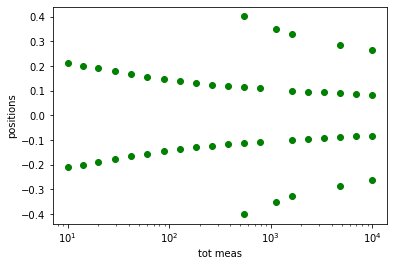

In [24]:
#Illustration of measurement positions depending on m

m=10
#sa=np.sqrt(s_2*m)
sa=np.exp(-muu/4)
s=1
for m in np.logspace(1,4,20):
    m=int(m)
    xp,wp,mpos=allocator(muu,m,sa=sa, s=s, t="BLGE")
    plt.scatter(m*np.ones(len(xp)),xp,c="g")
plt.semilogx()
plt.xlabel("tot meas")
plt.ylabel("positions")

In [49]:
#procedure to learn theta_0=h_0 preparation:

i=2 #this denotes the parameter, that we want to learn: h_i
j=i+1
k=i-1
if j==n:
    j=0
if k==-1:
    k=n-1
    

P_help=Pauli([i],['Y'],n)

indi=np.zeros(n) #this Vector are the entrys of corresponding indices. It will be used for all 4 vectors.
#it will be modified one by one:

#first |psi1>:
indi[i]=2    #remember: ind=2 is equal to a |+> state
psi1=nqubit(indi,n)

#then |psi2>:
indi[k]=1
psi2=nqubit(indi,n)

#now |psi4>:
indi[j]=1
psi4=nqubit(indi,n)

#and last |psi3>:
indi[k]=0
psi3=nqubit(indi,n)

#write them in one vector

psij=[psi1,psi2,psi3,psi4]



In [50]:
#now calculate theta_0 with BLGE method for the derivative of P_help

ppi=np.zeros(len(xp))
theta_0_guess=0
for i in range(len(xp)):
    U=sp.linalg.expm(-1j*xp[i]*H)
    for j in range(4):
        psijj=U@psij[j]  #|\psi_j>(t_i)
        a=np.conj(psijj)@P_help@psijj
        ppi[i]+=a/4
    theta_0_guess+=wp[i]*ppi[i]
print(theta_0_guess)

/tmp/ipykernel_21362/985663672.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  ppi[i]+=a/4


0.4287332103659853


In [45]:
print(ppi)

[ 0.07435495  0.0215868  -0.0215868  -0.07435495]


In [72]:

a=nqubit(np.zeros(n),n)+nqubit(np.zeros(n)+1,n)
print(a)
b=nqubit(np.zeros(n)+2,n)
print(b)
c=np.transpose(a)@b
print(c)

[1. 0. 0. ... 0. 0. 1.]
[0.015625 0.015625 0.015625 ... 0.015625 0.015625 0.015625]
0.03124999999999997


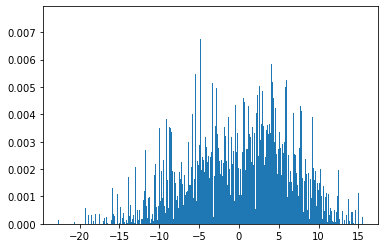

<Figure size 576x576 with 0 Axes>

In [33]:
plt.hist(l,bins=700,weights=w,)
plt.show()

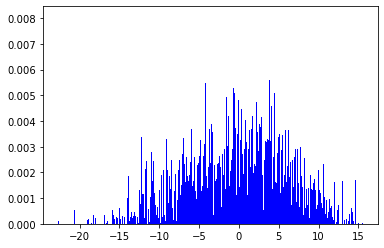

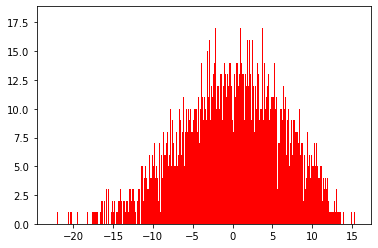

In [42]:
phi=(np.random.randn(2**n))
phi=phi/la.norm(phi,2) #normalization
w=np.abs(v[:,].T@phi)**2  # vector with|<phi|v[:,i]>|^2 entries
#             w=[np.abs(v[2**(n-1)-1,i])**2 for i in range(2**n)]
plt.hist(l,bins=700,weights=w, color='b',label='<H>_psi')
plt.show()
plt.hist(l,bins=700, color='r', label='<H>_hist')
plt.show()
#plt.text(-20,0.065, 'h=1')
#plt.ylabel('probability')
#plt.xlabel('energy')


In [27]:
l,v=la.eigh(H)


In [8]:
#this is the rediscretization/histogram-kind

#l,v=la.eigh(H) #getting eigenvalues l and eigenvectors v of H
ll=np.linspace(np.min(l),np.max(l),50)
Proj=np.zeros((len(ll),2**n,2**n),dtype=complex) #these are all the projectors onto one eigenvalue-room of H
eps=0.4
#Eig=np.zeros(2**n+1)
k=0

#eigs=[]
#kl=[np.argmin(np.abs(llist-lk)) for lk in ll] 
for i,li in enumerate(ll):
    val=np.abs(l-li)<=(ll[1]-ll[0])/2
    #print(val,li,l[0],sum(val),la.norm(v[:,val]))
    Proj[i]=v[:,val]@np.conj(v[:,val].T)
    #Proj[k]=np.einsum("aj,kj,j->ak",v,np.conj(v),)
#for i in range(2**n):
#    k=np.argmin(np.abs(llist-l[i]))
#    Proj[k]+=np.outer(v[:,i],np.conj(v[:,i]))
    #if np.abs(l[i]-Eig[k-1])>=eps:
        
    #    Eig[k]=l[i]
    #    k+=1
#Eig=Eig[:k]
#Proj=Proj[:k]
#print(k)
#Eig=np.zeros(k)
#for j in range(k):
#    Eig[j]=np.real(round(Eigv[j]))
#print(Eig)

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


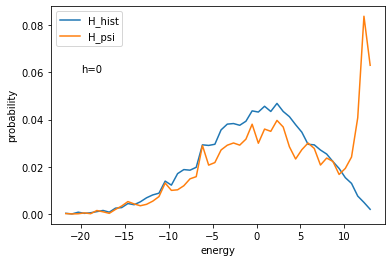

In [15]:
plt.plot(ll,[np.trace(P)/2**n for P in Proj], label='H_hist')
plt.plot(ll,[np.conj(phi.T)@P@phi for P in Proj], label='H_psi')#/np.trace(P)*2**n
plt.ylabel('probability')
plt.xlabel('energy')
plt.text(-20,0.06, 'h=0')
plt.legend()
plt.show()
#print(phi.T@H@phi,np.trace(H)/2**n)

In [36]:
###### new method, translated from language C

def nbits(s): #quasi Quersumme
    count = 0
    while s:
        s &= s - 1
        count += 1
    return count


def nck(n, k): # n über k
    r = 1
    for i in range(1, k + 1):
        r = r * (i + n - k) // i
    return r


def kw2i(n, k, s): #übersetzt dec in section Schreibweise
    c = nck(n, k)
    r = 0
    while n:
        c0 = c * (n - k) // n
        c1 = c * k // n
        if s & (1 << (n - 1)):
            r += c0
            c = c1
            k -= 1
        else:
            c = c0
        n -= 1
    return r


def i2kw(n, k, r): #übersetzt section Schreibweise in gewohnte dec des hamiltonians 
    c = nck(n, k)
    s = 0
    while n:
        c0 = c * (n - k) // n
        c1 = c * k // n
        if r >= c0:
            s |= 1 << (n - 1)
            r -= c0
            c = c1
            k -= 1
        else:
            c = c0
        n -= 1
    return s



In [65]:
N = 16
K = 4
count = 0
for i in range(1 << N):
    if nbits(i) == K:
        r = kw2i(N, K, i)
        s = i2kw(N, K, r)
        print(f"{i:016b} ==> {r:3d} ==> {s:04x}==> {s:05d}")
        assert count == r
        assert s == i
        count += 1

assert count == nck(N, K)


0000000000001111 ==>   0 ==> 000f==> 00015
0000000000010111 ==>   1 ==> 0017==> 00023
0000000000011011 ==>   2 ==> 001b==> 00027
0000000000011101 ==>   3 ==> 001d==> 00029
0000000000011110 ==>   4 ==> 001e==> 00030
0000000000100111 ==>   5 ==> 0027==> 00039
0000000000101011 ==>   6 ==> 002b==> 00043
0000000000101101 ==>   7 ==> 002d==> 00045
0000000000101110 ==>   8 ==> 002e==> 00046
0000000000110011 ==>   9 ==> 0033==> 00051
0000000000110101 ==>  10 ==> 0035==> 00053
0000000000110110 ==>  11 ==> 0036==> 00054
0000000000111001 ==>  12 ==> 0039==> 00057
0000000000111010 ==>  13 ==> 003a==> 00058
0000000000111100 ==>  14 ==> 003c==> 00060
0000000001000111 ==>  15 ==> 0047==> 00071
0000000001001011 ==>  16 ==> 004b==> 00075
0000000001001101 ==>  17 ==> 004d==> 00077
0000000001001110 ==>  18 ==> 004e==> 00078
0000000001010011 ==>  19 ==> 0053==> 00083
0000000001010101 ==>  20 ==> 0055==> 00085
0000000001010110 ==>  21 ==> 0056==> 00086
0000000001011001 ==>  22 ==> 0059==> 00089
00000000010

In [72]:
Sz=sum([Pauli([i],["Z"],n) for i in range(n)])
Sy=sum([Pauli([i],["Y"],n) for i in range(n)])
Sx=sum([Pauli([i],["X"],n) for i in range(n)])
S2=Sz@Sz+Sy@Sy+Sx@Sx
la.norm(Sz@H-H@Sz),la.norm(Sy@H-H@Sy),la.norm(S2@H-H@S2)

(0.0, 22.740318205457736, 163.86398402589953)

In [21]:
def fast_bin_to_sec(i,n,m):
    #n 10001
    if qs(i)==m:
        R=np.array(get_m(m,n))
        K=(R==i)
        #if sum(K)==0:
        #    return -1
        return np.argmax(K)
    else:
        return -1
def bin_to_sec(i,n,m):
    #n 10001
    R=np.array(get_m(m,n))
    K=(R==i)
    if sum(K)==0:
        return -1
    return np.argmax(K)
def sec_to_bin(i,n,m):
    #n 7
    R=get_m(m,n)
    return R[i]


In [114]:
Hl=Pauli([0,1],["X","X"],2)+Pauli([0,1],["Y","Y"],2)+Pauli([0,1],["Z","Z"],2)
l,v=la.eigh(Hl)
l,v[:,1]

(array([-3.,  1.,  1.,  1.]), array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]))

In [34]:
 fast_bin_to_sec(4032,12,6),bin_to_sec(4032,12,6),fast_bin_to_sec(4031,6,12),qs(4032)

(923, 923, -1, 6)

In [31]:
%timeit  fast_bin_to_sec(4032,12,6)
%timeit  bin_to_sec(4032,12,6)

7.35 ms ± 138 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.5 ms ± 185 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
%timeit  fast_bin_to_sec(4031,12,6)
%timeit  bin_to_sec(4031,12,6)

1.86 µs ± 24.7 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
11.1 ms ± 168 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
bin_to_sec(4031,6,12)

-1

In [33]:
def Pauli2(pos,typ,N,m):
    inds=np.argsort(pos)
    pos=np.array(pos)[inds]
    typ=np.array(typ)[inds]
    dim=int(sp.special.binom(N,m))
    res=np.zeros((dim,dim),dtype=complex)
    for n_s in range(dim):#range(2**N): now the range is N over m. n_s==n in section
        n=sec_to_bin(n_s,N,m) #translation of n_s in our used writing 
        #if quersumme(n)==m
        ind=0
        c=1+0j #this will be our entry, that we add in the matrix. The value will depend on the type of Pauli-Matrix
        nb=n
        for i in range(N):
            if i in pos:
                if typ[ind]=='X':
                    nb^=2**i # bitflip for binary's i's entry (0 to 1 and v.v.)
                elif typ[ind]=='Z':
                    #print(n," ",nb&(2**i))
                    c*=(-1)**((n>>i)%2)#(nb&(2**i)!=0) # n
                elif typ[ind]=='Y':
                    c*=-1j*(-1)**((n>>i)%2) # case distinguish: for (i'th pos in n)=0 => c=-i, for =1 =>c=+i
                    nb^=2**i # this is the same as for an x-operation
                ind+=1
        n_sb=fast_bin_to_sec(nb,N,m) #this is the translation into the writing of section Hm
        if n_sb==-1: #here we cover the case, that n_b is not in the list of get_m(m,n)
            #print(n,nb)
            continue
        res[n_s,n_sb]=c #writing entry in the notation of the section-Hamiltonian Hm
        res[n_sb,n_s]=np.conj(c) #complex conjugated entry
    return res

In [87]:
# Hamiltonian for ETH code in section n/2
H_sec=np.zeros((dim_sec,dim_sec),dtype=complex)
for i in range(n):
    H_sec+=(np.random.rand()-0.5)*Pauli2([i],['Z'],n,m)
    H_sec+=Pauli2([i,(i+1)%n],['X','X'],n,m)
    H_sec+=Pauli2([i,(i+1)%n],['Y','Y'],n,m)
    H_sec+=Pauli2([i,(i+1)%n],['Z','Z'],n,m)

1010101010 341


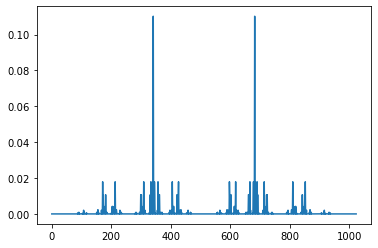

In [129]:

p=np.abs(u[:,0])**2
print("{0:b}".format(np.argmax(p)),ind0)
plt.plot(p)

0101010101
-18.55517236389728


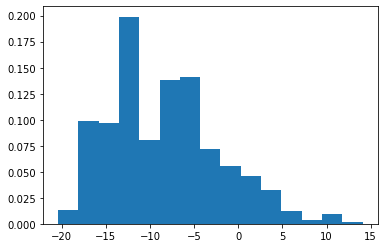

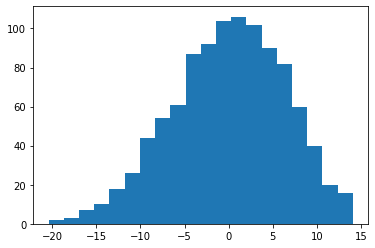

In [198]:
l,u=la.eigh(H)
ind0=np.random.randint(2**n)#2**(n//2)-1
ind0=sum(2**(2*i) for i in range(n//2))%2**n
print("{0:b}".format(ind0+2**n)[1:])
w=np.abs(u[ind0,:]+0*u[np.argmax(p),:])**2
w=np.abs(u[ind0,:]+0*u[np.argmax(p),:])**2
print(l[2])
psi0=np.zeros(len(H))
psi0[2**(n//2)-1]=1

plt.hist(l,bins=15,weights=w)
plt.show()
plt.hist(l,bins=20)
plt.show()

(array([ 3.,  4., 14., 21., 32., 43., 49., 38., 30., 18.]),
 array([-18.32250965, -15.46816769, -12.61382574,  -9.75948378,
         -6.90514183,  -4.05079987,  -1.19645792,   1.65788404,
          4.51222599,   7.36656795,  10.2209099 ]),
 <BarContainer object of 10 artists>)

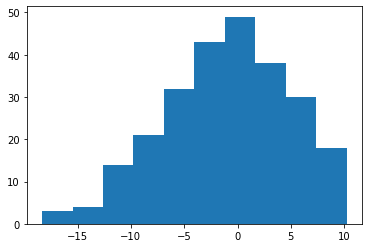

In [88]:
l=la.eigvalsh(H_sec)
plt.hist(l)

In [50]:
for i,Rk in enumerate(R):
    print("{0:b}".format(2**n+Rk)[1:],"  ", i)


000000111111    0
000001011111    1
000001101111    2
000001110111    3
000001111011    4
000001111101    5
000001111110    6
000010011111    7
000010101111    8
000010110111    9
000010111011    10
000010111101    11
000010111110    12
000011001111    13
000011010111    14
000011011011    15
000011011101    16
000011011110    17
000011100111    18
000011101011    19
000011101101    20
000011101110    21
000011110011    22
000011110101    23
000011110110    24
000011111001    25
000011111010    26
000011111100    27
000100011111    28
000100101111    29
000100110111    30
000100111011    31
000100111101    32
000100111110    33
000101001111    34
000101010111    35
000101011011    36
000101011101    37
000101011110    38
000101100111    39
000101101011    40
000101101101    41
000101101110    42
000101110011    43
000101110101    44
000101110110    45
000101111001    46
000101111010    47
000101111100    48
000110001111    49
000110010111    50
000110011011    51
000110011101    52
000

In [39]:
%timeit K=R==i
K=R==i
%timeit np.sum(K)
%timeit K=np.sum(R==i)

3.18 µs ± 61.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
10.3 µs ± 183 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
15.4 µs ± 338 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [60]:
psi=np.zeros(int(sp.special.binom(n,n//2)))
psi[bin_to_sec_fix(2**(n//2)-1)]=1
psi

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [33]:
def f(i):
    for ind in range(len(R)):
        if R[ind]==i:
            return ind
    return -1

In [63]:
def bin_to_sec_fix(i):
    ind=np.argmax(R==i)
    if R[ind]!=i:
        return -1
    return ind
def bin_to_sec_fix2(i):
    ind=np.argmax(R==i)
    if R[ind]!=i:
        return -1
    return ind

In [18]:
R=np.array(get_m(m,n))
def bin_to_sec_fix(i):
    K=(R==i)
    if sum(K)==0:
        return -1
    return np.argmax(K)
def sec_to_bin_fix(i):
    return R[i]


In [25]:
def Pauli2_fix(pos,typ):
    inds=np.argsort(pos)
    pos=np.array(pos)[inds]
    typ=np.array(typ)[inds]
    dim=int(dim_sec)
    res=np.zeros((dim,dim),dtype=complex)
    for n_s in range(dim):#range(2**N): now the range is N over m. n_s==n in section
        n=sec_to_bin_fix(n_s) #translation of n_s in our used writing 
        ind=0
        c=1+0j #this will be our entry, that we add in the matrix. The value will depend on the type of Pauli-Matrix
        nb=n
        for i in range(n):
            if i in pos:
                if typ[ind]=='X':
                    nb^=2**i # bitflip for binary's i's entry (0 to 1 and v.v.)
                elif typ[ind]=='Z':
                    #print(n," ",nb&(2**i))
                    c*=(-1)**((n>>i)%2)#(nb&(2**i)!=0) # n
                elif typ[ind]=='Y':
                    c*=-1j*(-1)**((n>>i)%2) # case distinguish: for (i'th pos in n)=0 => c=-i, for =1 =>c=+i
                    nb^=2**i # this is the same as for an x-operation
                ind+=1
        n_sb=bin_to_sec_fix(nb) #this is the translation into the writing of section Hm
        if n_sb==-1: #here we cover the case, that n_b is not in the list of get_m(m,n)
            #print(n,nb)
            continue
        res[n_s,n_sb]=c #writing entry in the notation of the section-Hamiltonian Hm
        res[n_sb,n_s]=np.conj(c) #complex conjugated entry
    return res

In [23]:
Pauli2([0,1],['Z','Z'],2,1)

array([[-1.-0.j,  0.+0.j],
       [ 0.+0.j, -1.-0.j]])

In [9]:
(sec_to_bin(0,14,7),bin_to_sec(127,14,7))


(127, 0)

In [35]:
timeit(sec_to_bin_fix(2),bin_to_sec_fix(223))


15.3 ms ± 70.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


16

In [209]:
%timeit Pauli([0,1,4],['X','Y','X'],13)


3.43 s ± 7.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
304 ms ± 782 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
#choice of observable O as one single pauli Matrix
Obs=Pauli([0,n//2],['Z','Z'],n)


In [107]:
M=np.array([[0,1],[0,0]])
B=g(np.array(M)+0.00000000000000000000000000000001*np.random.randn(2,2))
A=sp.linalg.expm(1j*M)
A,B

(array([[1.+0.j, 0.+1.j],
        [0.+0.j, 1.+0.j]]),
 array([[ 1.00000000e+00+5.00755294e-33j,  0.00000000e+00+1.00000000e+00j],
        [-7.31839871e-33+8.13749303e-33j,  1.00000000e+00-5.73728839e-33j]]))

In [77]:
def f(H):
    l,v=sp.linalg.eigh(H)
    w=v*np.exp(1j*l)
    return v@np.transpose(w).conj()#np.einsum("ij,j,kj->ik",v,np.exp(1j*l),v.conj())
def g(H):
    l,v=sp.linalg.eig(H)
    w=la.inv(v)*np.exp(1j*l)
    return v@np.diag(np.exp(1j*l))@la.inv(v)

In [62]:
%time U=sp.linalg.expm(1j*H)
%time U2=f(H)
%time U3=g(H)
la.norm(U-U2.conj()),la.norm(U-U3)

CPU times: user 12.6 s, sys: 6.41 s, total: 19 s
Wall time: 1.03 s
CPU times: user 3.73 s, sys: 4.39 s, total: 8.12 s
Wall time: 488 ms
CPU times: user 6.59 s, sys: 4.36 s, total: 10.9 s
Wall time: 624 ms


(8.061478920454597e-13, 3.389464797053348e-13)

In [28]:
u1

NameError: name 'u1' is not defined

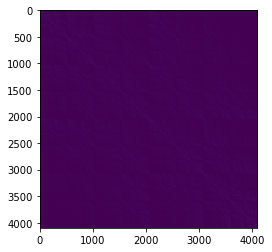

In [11]:
plt.imshow(np.abs(U))

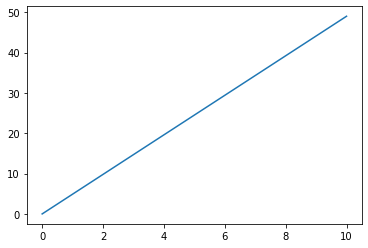

In [15]:
#in this section, we add the time-evolution. We let the system evolve up to t_max=10 in little steps.
#We write down the expectation value of the hamiltonian depending on time t and draw a graph of it.
#Also in the end, we look at the probability distribution for the energy measurement once again
#and compare to the beginning
tmax=10
steps=50
time=np.linspace(0,tmax,steps)
Energy=np.zeros(steps)
psiT=phi
U=sp.linalg.expm(1j*(time[1]-time[0])*H)
for g in range(steps):
    Energy[g]=g
        





plt.plot(time,Energy)

In [9]:
psiP=np.einsum("iab,b->ai",Proj,phi)
cij=np.conj(psiP).T@Obs@psiP
#cij=np.einsum("ai,ab,bj->ij",np.conj(psiP),Obs,psiP)

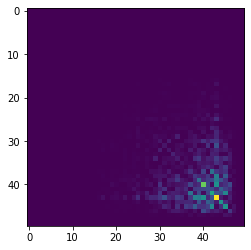

In [10]:
plt.imshow(np.abs(cij))
f=lambda t:np.sum([[cij[i,j]*np.exp(1j*t*(ll[i]-ll[j])) for i in range(len(ll))] for j in range(len(ll))])
ct=lambda t:np.array([[cij[i,j]*np.exp(1j*t*(ll[i]-ll[j])) for i in range(len(ll))] for j in range(len(ll))])

In [40]:
np.diag(cij) 

array([-8.88429781e-05+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        0.00000000e+00+0.j,  0.00000000e+00+0.j,  2.23825540e-04+0.j,
        0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        0.00000000e+00+0.j,  0.00000000e+00+0.j,  7.01313255e-04+0.j,
        0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
       -6.99860912e-05+0.j, -1.25248231e-03+0.j,  0.00000000e+00+0.j,
        0.00000000e+00+0.j, -5.20330988e-05+0.j,  3.01244818e-04+0.j,
        0.00000000e+00+0.j,  0.00000000e+00+0.j, -4.64012257e-05+0.j,
        3.34643337e-04+0.j,  0.00000000e+00+0.j,  3.15810575e-05+0.j,
       -3.49081518e-03+0.j,  4.84467891e-04+0.j,  0.00000000e+00+0.j,
        3.83672723e-04+0.j, -4.96240840e-03+0.j,  6.46055862e-04+0.j,
        5.95119551e-04+0.j,  9.20358411e-04+0.j, -1.17093172e-03+0.j,
        0.00000000e+00+0.j,  0.00000000e+00+0.j,  3.73833988e-03+0.j,
        7.86630109e-04+0.j,  0.00000000e+00+0.j, -5.59468744e-04+0.j,
       -2.93869771e-

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


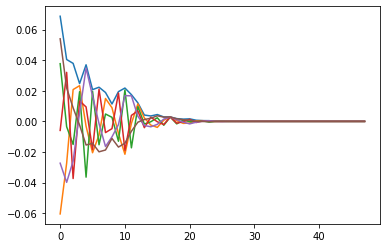

In [67]:
tk=np.linspace(0,10,6)
for t in tk:
    plt.plot([np.sum(np.diag(ct(t),k)) for k in range(2,len(ll))])

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


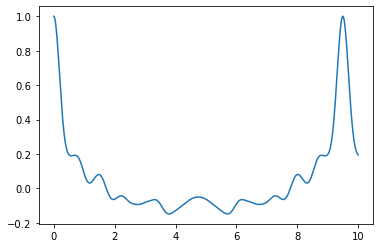

In [68]:
tl=np.linspace(0,10,1000)
plt.plot(tl,[f(t) for t in tl])
#plt.plot(tl,y)

In [43]:
y=[f(t) for t in tl]

In [50]:
np.abs(sum(Proj))

array([[1.00000000e+00, 6.93100582e-15, 5.79592211e-15, ...,
        6.08275541e-16, 3.12518831e-16, 5.46008488e-16],
       [6.93100582e-15, 1.00000000e+00, 4.91828038e-15, ...,
        1.16323114e-15, 1.53577416e-16, 3.81498651e-16],
       [5.79592211e-15, 4.91828633e-15, 1.00000000e+00, ...,
        1.23768600e-15, 6.89665331e-16, 1.10112789e-16],
       ...,
       [6.08275541e-16, 1.16577548e-15, 1.25338097e-15, ...,
        1.00000000e+00, 2.47716611e-15, 4.49198573e-15],
       [3.12518831e-16, 1.63756322e-16, 6.79274321e-16, ...,
        2.47716611e-15, 1.00000000e+00, 2.77301671e-16],
       [5.46008488e-16, 3.84650094e-16, 1.16804401e-16, ...,
        4.49198573e-15, 2.77301671e-16, 1.00000000e+00]])

In [69]:
a=np.array([np.trace(Proj[i,:,:])/2**n for i in range(len(ll))])
b=np.array([np.conj(phi.T)@P@phi for P in Proj])
np.sum(a)

(1.0000000000000002+0j)

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


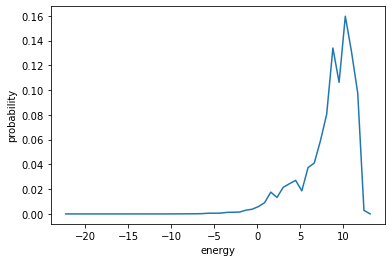

In [19]:
def Meas(psi,Pl,M):
    pl=np.real(np.array([np.conj(psi)@Pl[i]@psi for i in range(len(Pl))]))
    #print(pl)
    return np.random.multinomial(M,pl)/M

In [20]:
PlO=lambda i: [Pauli([i],['Zp'],n),Pauli([i],['Zm'],n)]



def fx(M,psi,H,x): # calculates the simulated experimental value of f(x)=(F(+x)-F(-x))/2
    U=sp.linalg.expm(1j*x*H)
    PlObs=PlO(n//2)
    psip=U@psi
    psim=np.conj(U)@psi
    fp=Meas(psip,PlObs,M)
    fm=Meas(psim,PlObs,M)
    return (fp[0]+fm[1]-fp[1]-fm[0])/2

In [13]:
def Hz(n, hn=None):
    if hn is None:
        h=1
        hn=2*h*(np.random.rand(n)-0.5) #the random number between -h and +h for each index
    Hzi=np.zeros([n,2**n,2**n])
    Hz=np.zeros((2**n,2**n))
    for x in range(0,n):
        if x==0:
            Hpart=np.kron(sigz,np.eye(2))
        if x==1:
            Hpart=np.kron(np.eye(2),sigz)
        if x>=2:
            Hpart=np.kron(np.eye(2),np.eye(2))
        for z in range (2,n):
            if x==z:
                Hpart=np.kron(Hpart,sigz)
            else:
                Hpart=np.kron(Hpart,np.eye(2))
        Hzi[x,:,:]=Hpart*hn[x]
    for i in range(0,n):
        Hz+=Hzi[i,:,:]
    return Hz
print(Hz)

<function Hz at 0x7f9bebd98e50>


In [14]:
def Hr(n):
    Hr=np.zeros((2**n,2**n),dtype=complex)
    for x in range(0, n):
        if x==0:
            Hpx=sigx
            Hpy=sigyi
            Hpz=sigz
        elif x==n-1:
            Hpx=sigx
            Hpy=sigyni
            Hpz=sigz
        else:
            Hpx=np.eye(2)
            Hpy=np.eye(2)
            Hpz=np.eye(2)
        for z in range(1,n):
            if x==z:
                Hpx=np.kron(Hpx,sigx)
                Hpy=np.kron(Hpy,sigyi)
                Hpz=np.kron(Hpz,sigz)
            elif x==z-1:
                Hpx=np.kron(Hpx,sigx)
                Hpy=np.kron(Hpy,sigyni)
                Hpz=np.kron(Hpz,sigz)
            else:                
                Hpx=np.kron(Hpx,np.eye(2))
                Hpy=np.kron(Hpy,np.eye(2))
                Hpz=np.kron(Hpz,np.eye(2))
        Hr+=(Hpx+Hpy+Hpz)
    return Hr
print(Hr)

<function Hr at 0x7f9bebd98430>


In [15]:
i=1 #to be chosen, between 1 and n
j=2 #should be kinda n/2
if i==1:
    sigi=sigz
else:
    sigi=np.eye(2)
if j==1:
    sigj=sigz
else:
    sigj=np.eye(2)
for k in range (1,n):
    if i==k+1:
        sigi=np.kron(sigi,sigz)
    else:
        sigi=np.kron(sigi,np.eye(2))
    if j==k+1:
        sigj=np.kron(sigj,sigz)
    else:
        sigj=np.kron(sigj,np.eye(2))
sigij=sigi@sigj

In [16]:
#Calc of the first part of Correlation C
h=0.5
H=Hr(n)+Hz(n,h*(2*np.random.rand(n)-1)) #the final hamiltonian with its two parts
D=1000 #number of timesteps
t=np.linspace(0,30,D) #time-vector
psi=phi #initialization
U=sp.linalg.expm(1j*(t[1]-t[0])*H) #the time evolution matrix U
Ca=np.zeros(D) #values of observable <sig_i*sig_j> to times t
for i in range (len(t)):
    psi=U@psi #=|psi>(t)
    val=np.conj(psi)@sigij@psi #=<psi(t)|O|psi>(t)
    Ca[i]=np.real(val)

In [17]:
l,v=la.eigh(H)

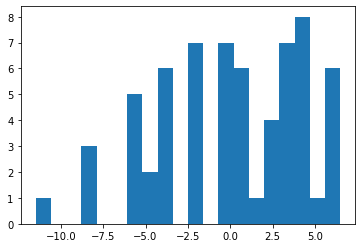

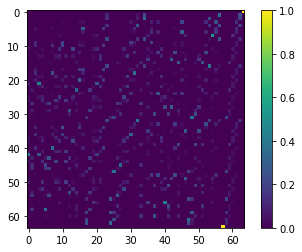

In [18]:
plt.hist(l,20)
plt.show()
plt.imshow(np.abs(v)**2)
plt.colorbar()

In [19]:
#Calc of the second part of Correlation C
psi=phi
Cb=np.zeros(D)
Cc=np.zeros(D)
for i in range (len(t)):
    psi=U@psi
    val1=np.conj(psi)@sigi@psi
    val2=np.conj(psi)@sigj@psi
    Cb[i]=np.real(val1)
    Cc[i]=np.real(val2)

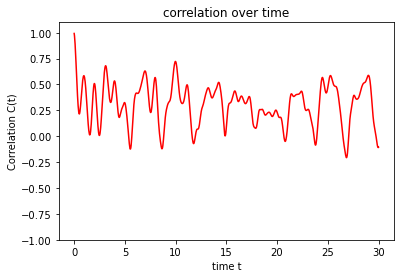

In [20]:
C=Ca-Cb*Cc
plt.title("correlation over time")
plt.xlabel("time t")
plt.ylabel("Correlation C(t)")
plt.plot(t,C,color="red")
plt.ylim([-1,1.1])
plt.show()

In [21]:
np.random.multinomial(20, [1/6.]*2)

array([ 6, 14])

In [24]:
Pls=lambda i,j: [Pauli([i,j],['Zp','Zp'],n),Pauli([i,j],['Zp','Zm'],n),Pauli([i,j],['Zm','Zp'],n),Pauli([i,j],['Zm','Zm'],n)]

def Cexp(pos,M,psi): # calculates the simulated experimental value of C
    P=Pls(pos[0],pos[1])
    f=Meas(psi,P,M)
    sisj=(f[0]-f[1]-f[2]+f[3])
    si=f[0]+f[1]-f[2]-f[3]
    sj=f[0]-f[1]+f[2]-f[3]
    return sisj-si*sj

In [25]:
Pls=lambda i,j: [Pauli([i,j],['Zp','Zp'],n),Pauli([i,j],['Zp','Zm'],n),Pauli([i,j],['Zm','Zp'],n),Pauli([i,j],['Zm','Zm'],n)]

Plss=lambda i: [Pauli([i],['Zp'],n),Pauli([i],['Zm'],n)]

def Cexp2(pos,M,psi): # a second method
    P1=Pls(pos[0],pos[1])
    f1=Meas(psi,P1,M)
    P2=Plss(pos[0])
    f2=Meas(psi,P2,M)
    P3=Plss(pos[1])
    f3=Meas(psi,P3,M)
    
    sisj=(f1[0]-f1[1]-f1[2]+f1[3])
    si=f2[0]-f2[1]
    sj=f3[0]-f3[1]
    return sisj-si*sj

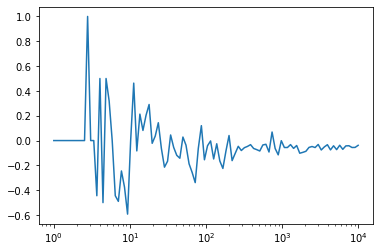

In [42]:
n=6
psi=np.random.randn(2**n)+1j*np.random.randn(2**n)
psi/=np.linalg.norm(psi)
yl=[]
for M in np.logspace(0,4,100):
    yl+=[Cexp([0,2],int(M),psi)]
plt.semilogx(np.logspace(0,4,100),yl)
#print(yl)

(0.0, 1.0)

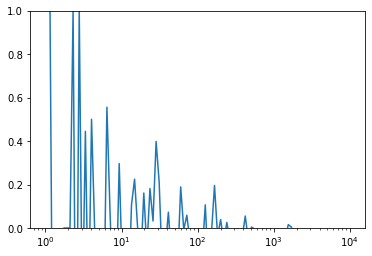

In [43]:
#n=10
#psi=np.random.randn(2**n)
#psi/=np.linalg.norm(psi)
yl=[]
for M in np.logspace(0,4,100):
    yl+=[Cexp2([0,2],int(M),psi)]
plt.semilogx(np.logspace(0,4,100),yl)
plt.ylim([0,1])
#print(yl)

In [48]:
#simulating an experiment, measuring 100 times Pauli-Z on i'th Qubit

M=1000 # number of measurements
Proj1=np.array([[1, 0],[0 ,0]]) # Projector for Z1=0
Proj2=np.array([[0, 0],[0 ,1]])  # Projector for Z1=1
for x in range(1,n):
    Proj1=np.kron(Proj1,np.eye(2))
    Proj2=np.kron(Proj2,np.eye(2))
#p=np.zeros(len(t))
Pl=[Proj1,Proj2]

psi=phi
#for i in range (len(t)):

psi=U@psi #=|psi>(t)

print(Meas(psi,Pl,M))
f=Meas(psi,Pl,M)

#print(f)
RN=np.random.rand(1) # a random number between 0 and 1
cont=0 # a control number, as long as "RN" is higher than this, we add one more tails
f1=0 #frequency of getting outcome 1 with M measurements
p=f[0]
for i in range (0,M+1):
    cont+=binom(M,i)*(p**i)*(1-p)**(M-i)
    if RN[0] >=cont:
        f1 +=1
print(p)
print(RN[0])
print(f1)
Oexp=(f1/M)*1+(1-f1/M)*(-1)
print(Oexp)

[0.494 0.506]
0.495
0.4964153718429408
495
-0.010000000000000009


In [46]:
from scipy.special import binom

In [32]:
#comparison between experiment and real value:
psi=phi
psi=U@psi #=|psi>(t)
val=np.conj(psi)@sigi@psi
Oreal=np.real(val)
#print(Oexp)
print(Oreal)

-0.003586386680795349
